# PINNs on Graphs

This notebook accompanies the paper


---

In this notebook, we describe and illustrate the methodology proposed in the aforementioned paper.
Here, we deal with the solution of a drift-diffuion equation on a metric graph.
A metric graph is an undirected graph that consists of a set of vertices $\mathcal V$ and edges $\mathcal E$ where in contrast to combinatorial graphs a length $l_e$ is assigned to each edge $e \in \mathcal E$.
Each edge $e \in \mathcal E$ connects a pair of nodes $(v_{e_a},v_{e_b})$ with $v_{e_a}, v_{e_b} \in \mathcal V$

We consider the drift-diffusion equation posed on each edge

$$
\partial_t u = \partial_x ( \varepsilon \partial_x \rho_e - f(\rho_e) \partial_x V_e), \quad e \in \mathcal E
$$

where $\rho_e : [0,l_e] \times (0,T) \to \mathbb{R}_+$ describes, on each edge, the concentration of some quantity while $V_e: [0,l_e] \times(0,T)\to \mathbb{R}_+$ is a given potential and $\varepsilon > 0$ a given constant, typically small.

To make this a well-posed problem, we need a set of initial conditions as well as coupling conditions in the vertices.
- For vertices $v \in \mathcal V_{\mathcal K} \subset \mathcal V$, we apply homogeneous Neumann-Kirchhoff conditions, i.e., there holds
$$
\sum_{e \in \mathcal{E}_v} J_e \, n_{e} (v) = 0 \quad v \in \mathcal V_{\mathcal K},
$$
where we additionally ask the solution to be continuous over the edges, i.e.
$$
p_e(v) = p_{e^{'}}(v)
\quad \text{for all } v \in \mathcal{V}_{\mathcal K}, e, e^{'} \in \mathcal{E}_v
$$
with $\mathcal E_v$ the edge set incident to the vertex $v$.
- For vertices $v \in \mathcal V_{\mathcal D} := \mathcal V \setminus \mathcal{V}_{\mathcal K}$ the solution fulfills flux boundary conditions
$$
J_e \, n_e (v) = - \alpha_v \, (1-u_v) + \beta_v \, u_v \quad \text{for all } e \in \mathcal E_v.
$$

Import necessary packages.

In [1]:
import tensorflow as tf
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In /home/blja/miniconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/blja/miniconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/blja/miniconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/blja/miniconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


## Set up class GraphPINNs

Next, we define the class `GraphPINN`, which is employed in the subsequent code.
The idea is to have one vanilla `PINN` for each edge which are connected via boundary and vertex conditions which are enforced weakly.

---

First, we define the model for a `PINN` which consists of one scaling layer, a number of fully connected hidden layers and one final output layer.

In [2]:
# Define model architecture
class PINN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=6,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Scaling layer to map inpot to the interval [-1, 1]
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0)
        
        # Inititialize num_hidden_layers many fully connected dense layers
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        
        # Output layer
        self.out = tf.keras.layers.Dense(output_dim, activation=None)

    def call(self, X):
        """Forward-pass through neural network."""
        
        Z = self.scale(X)
        
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
            
        return self.out(Z)

In this notebook, we rely on the package [NetworkX](https://networkx.org/).
An alternative approach would be to employ [igraph](https://igraph.org/), which seems to be more lightweight.

Next, we set up the class for a graph PINN which takes either an adjacency matrix $A$ or a `MultiDiGraph` as input `inp` to define the network as well as the Dirichlet data as a list of pairs $(i, u_i)_{i=1}^{n_D}$ corresponding to $u(v_i) = u_i$.
*Notes*:
- we define our graph as a `MultiDiGraph` since graphs imported from [OpenStreetMap](https://www.openstreetmap.de/) obey this format.

In [9]:
import networkx as nx

class GraphPINN():
    
    def __init__(self, inp, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub):
        
        if isinstance(inp, nx.classes.multidigraph.MultiGraph):
            self.G = inp
            self.A = nx.adjacency_matrix(G).toarray()
            
        elif tf.is_tensor(A) and len(A.shape)==2:
            # Store adjacency matrix
            self.A = A
            # Define networkx multigraph
            self.G = nx.MultiDiGraph(A.numpy())
            
        else:
            raise ValueError('Check input type of GraphPINN.')
        
        self.dirichletNodes = dirichletNodes
        self.dirichletAlpha = dirichletAlpha
        self.dirichletBeta = dirichletBeta
        
        self.lb = lb
        self.ub = ub
        
        # Get number of vertices
        self.n_v = self.A.shape[0]
        
        # Determine lists of edges and lengths
        self._determineEdgeList()
        
        # Determine list of vertices and incoming as well as outgoing edges
        self._determineVertexList()
        
        # Setup list of neural networks
        self._setupNNs()
        
        # Setup list of vertex values in inner nodes
        self._setupVertexVariables()
        
    def _determineEdgeList(self):
        """Determine edge matrix and weight vector.
        This could also be accomplished by a loop over `G.edges`:
            for e in G.edges:
                print(e)
        """
        
        self.E = []
        self.W = []
        
        for i in range(self.n_v):
            for j in range(i + 1, self.n_v):
                aij = self.A[i, j]
                if aij > 0:
                    #print('Connectivity between i: {} and j: {}'.format(i,j))
                    self.E.append([i, j])
                    self.W.append(aij.numpy())

        # Get number of edges
        self.n_e = len(self.E)
        
    def _determineVertexList(self):
        
        self.Vin = [[] for _ in range(self.n_v)]
        self.Vout = [[] for _ in range(self.n_v)]
        
        for i, e in enumerate(self.E):
            # Unpack edge
            vin, vout = e
            self.Vin[vout].append(i)
            self.Vout[vin].append(i)            
            
        self.innerVertices = np.setdiff1d(np.arange(self.n_v), self.dirichletNodes)
            
    def _setupNNs(self):
        
        self.NNs = []
        for i, e in enumerate(self.E):
            self.NNs.append(PINN(lb=self.lb, ub=self.ub))
    
        print('Initialized {:d} neural nets.'.format(len(self.NNs)))
    
    def _setupVertexVariables(self):
        # TODO: dimension of variables explicit here!
        
        self.vertexVals = []
        for i in self.innerVertices:
            self.vertexVals.append(tf.Variable(tf.zeros(400,), trainable=True, dtype=DTYPE))
        
    def plotGraph(self, **kwargs):
        
        # Determine graph layout if necessary
        if not hasattr(self, 'pos'):
            self.pos = nx.kamada_kawai_layout(self.G)
            
        nx.draw(self.G, pos=self.pos, with_labels=True, **kwargs)

### Example

First, we define a network which is determined by its
adjacency matrix $A \in \mathbb{R}_+^{n_v \times n_v}$ with $n_v$ the number of vertices.
Note that this matrix is not symmetric, as it belongs to a *directed* graph.
Here, an entry $a_{i,j} > 0$ indicates that there is an edge starting in vertex $i$ and ending in vertex $j$ with length $a_{i,j}$.

In [39]:
DTYPE = 'float32'
adj = 5

# Specify adjacency matrix
if adj == 1:
    A = tf.constant([[0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0]
                ], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 1.
    xmin = 0.
    xmax = 0.1
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 7])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.0])
    dirichletBeta = np.array([0.0, 0.5])
                              
    
    eps = 0.01
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)

    
elif adj == 2:
    A = tf.constant([[0, 1],
                 [1, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 4.
    xmin = -1.
    xmax = 1.
    
    u0 = lambda x : -tf.sin(x*np.pi)
    dirichletNodes = np.array([0, 1])
    dirichletVals = np.array([0.0, 0.0])
    def pde(u, ut, ux, uxx):
        return ut - 0.01/np.pi * uxx + u*ux
    
elif adj == 3:
    A = tf.constant([[0, 1, 0],
                     [1, 0, 1],
                     [0, 1, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 1.
    xmin = 0.
    xmax = 1.
    
    #u0 = lambda x : -tf.sin(x*2*np.pi)
    u0 = lambda x : -tf.sin(x*np.pi)

    dirichletNodes = np.array([0, 2])
    dirichletVals = np.array([0.0, 0.0])

    def pde(u, ut, ux, uxx):
        return ut - .1*uxx
    
elif adj == 4:
    A = tf.constant([[0, 0, 1,0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1],
                 [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 4.
    xmin = 0.
    xmax = 1.
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 1, 3])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.8, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.])
                              
    
    eps = 1e-6
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
elif adj == 5:
    A = tf.constant([[0, 0, 1, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 1, 1],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 1, 4, 5])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.9, 0.3, 0., 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.8, 0.1])
                              
    
    eps = 1e-2
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)


# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)

# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

Initialized 5 neural nets.
Vin: [[], [], [0, 1], [2], [3], [4]]
Vout: [[0], [1], [2], [3, 4], [], []]


[[0, 2], [1, 2], [2, 3], [3, 4], [3, 5]]

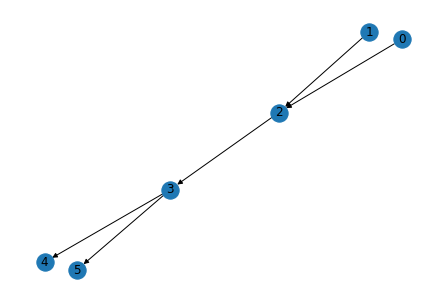

In [40]:
%matplotlib inline

gPINN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub)
gPINN.plotGraph()
print('Vin:', gPINN.Vin)
print('Vout:', gPINN.Vout)
gPINN.E

Draw collocation points uniformly or take them equidistantly distributed.

In [41]:
mode = 'deterministic'
mode = 'uniform'

N_0 = 400
N_b = 400
N_r = 4000

if mode == 'deterministic':

    # Uniform distributed collocation points
    t_r = tf.linspace(lb[0], ub[0], N_0+1)
    x_r = tf.linspace(lb[1], ub[1], N_b+1)
    tt, xx = tf.meshgrid(t_r,x_r)
    X_r = tf.concat([tf.reshape(tt,(-1,1)), tf.reshape(xx,(-1,1))], axis=1)

elif mode == 'uniform':
    
    # Set random seed for reproducible results
    tf.random.set_seed(0)
    
    X_r = tf.random.uniform((N_r,2), lb, ub, dtype=DTYPE)
    
    # Draw uniform sample points for initial boundary data
    t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
    x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
    X_0 = tf.concat([t_0, x_0], axis=1)
    
    # Boundary data
    t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
    x_b1 = tf.ones((N_b,1), dtype=DTYPE) * lb[1]
    X_b1 = tf.concat([t_b, x_b1], axis=1)
    
    x_b2 = tf.ones((N_b,1), dtype=DTYPE) * ub[1]
    X_b2 = tf.concat([t_b, x_b2], axis=1)

    # Draw uniformly sampled collocation points
    t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
    x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
    X_r = tf.concat([t_r, x_r], axis=1)
    X_data = tf.concat([X_0, X_b1, X_b2, X_r], axis=0)

Draw collocation points.

Text(0, 0.5, 'x')

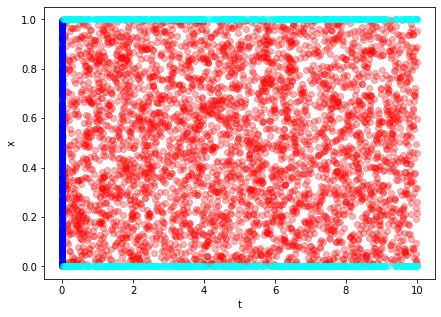

In [42]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
ax.scatter(X_r[:,0].numpy(), X_r[:,1].numpy(),color='red',alpha=0.3)
ax.scatter(tf.ones_like(x_0)*lb[0], x_0, color='blue', alpha=0.5)
ax.scatter(t_b, tf.ones_like(t_b)*lb[1], color='cyan', alpha=0.5)
ax.scatter(t_b, tf.ones_like(t_b)*ub[1], color='cyan', alpha=0.5)
ax.set_xlabel('t')
ax.set_ylabel('x')

## Set up class for time-dependent equations

We have to handle different kinds of boundary and vertex conditions:
- all inner vertices: Kirchhoff-Neumann conditon
- initial time conditions on all edges
- Dirichlet conditions on selected vertices as long as it is an inflowing node

In [43]:
from time import time

class graphPINNSolver(object):
    def __init__(self, graphPINN, X_data):
        
        # Store collocation points
        self.N_r = X_r.shape[0]
        
        self.graphPINN = graphPINN
        
        n_e = self.graphPINN.n_e
        
        self.X_data = X_data
        self.t = [ X_data[:,0:1]
                      for i in range(n_e)]
        self.x = [ X_data[:,1:2]
                      for i in range(n_e)]
        
        self.n_t0 = slice(0, N_0)
        self.n_x0 = slice(N_0, N_0+N_b)
        self.n_xL = slice(N_0+N_b, N_0 + 2*N_b)
        self.n_inner = slice(N_0 + 2*N_b,None)


        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        
        # Call each network once to initialize trainable variables
        self.trainable_variables = []
        for i in range(n_e):
            self.graphPINN.NNs[i](tf.constant([[1., 1.]]))
            self.trainable_variables.append(self.graphPINN.NNs[i].trainable_variables)

        #self.trainable_variables = [self.graphPINN.NNs[i].trainable_variables
        #                            for i in range(n_e)]
        for i, v in enumerate(self.graphPINN.innerVertices):
            self.trainable_variables.append([self.graphPINN.vertexVals[i]])

    def get_fvals1(self, t=None, x=None):

        # Initilize lists for values and derivatives
        u = []
        u1x = []
        u1t = []
        
        if t is None:
            t = self.t
        if x is None:
            x = self.x
            
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(t)
            tape.watch(x)
            
            # Compute current values u(t,x)
            u = []
            for i in range(self.graphPINN.n_e):
                u.append(self.graphPINN.NNs[i](tf.stack([t[i][:,0], x[i][:,0]], axis=1)))
                
        for i in range(self.graphPINN.n_e):
            u1t.append(tape.gradient(u[i], t[i]))
            u1x.append(tape.gradient(u[i], x[i]))

        del tape

        return u, u1t, u1x
    
    def get_fvals2(self, t=None, x=None):

        # Initilize lists for values and derivatives
        u = []
        u1x = []
        u2x = []
        u1t = []
        
        if t is None:
            t = self.t
        if x is None:
            x = self.x
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(t)
            tape.watch(x)
            
            # Compute current values u(t,x)
            u = []
            for i in range(self.graphPINN.n_e):
                u.append(self.graphPINN.NNs[i](tf.stack([t[i][:,0], x[i][:,0]], axis=1)))
                u1x.append(tape.gradient(u[i], x[i]))
                
        for i in range(self.graphPINN.n_e):
            u1t.append(tape.gradient(u[i], t[i]))
            u2x.append(tape.gradient(u1x[i], x[i]))
        
        del tape

        return u, u1t, u1x, u2x

    def fun_r2(self, u, u1t, u1x, u2x):
        ret = []
        for i in range(self.graphPINN.n_e):
            ret.append(pde(u[i], u1t[i], u1x[i], u2x[i]))

        return ret
    
    def fun_r1(self, u, u1t, u1x):
        ret = []
        for i in range(self.graphPINN.n_e):
            ret.append(u1t[i] + u1x[i] - 2*u[i]*u1x[i])

        return ret
    
    @tf.function
    def loss_fn(self):
        
        # Get values of functions and derivatives
        u, u1t, u1x, u2x = self.get_fvals2()
        
        # Compute phi_r
        r = self.fun_r2(u, u1t, u1x, u2x)
        
        loss_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = loss_r
        check_val = lambda x : print(x.shape)
        #check_val = lambda x :0
        
        # Short-hand notation of mean-squared loss
        mse = lambda x : tf.reduce_mean(tf.square(x))

        # Initial time condition
        loss_0 = 0
        for i in range(0,self.graphPINN.n_e):
            val = u[i][self.n_t0, 0] - u0(self.X_data[self.n_t0, 1])
            #check_val(val)
            loss_0 += mse(val)
        loss += loss_0
        
        # Continuity in inner vertices
        loss_c = 0
        for i,v in enumerate(self.graphPINN.innerVertices):
            for j in self.graphPINN.Vin[v]:
                val = u[j][self.n_xL, 0] - self.graphPINN.vertexVals[i]
                #check_val(val)
                loss_c += tf.reduce_sum(tf.square(val))
                #loss_c += mse(val)

            for j in self.graphPINN.Vout[v]:
                val = u[j][self.n_x0, 0] - self.graphPINN.vertexVals[i]
                #check_val(val)
                loss_c += tf.reduce_sum(tf.square(val))

                #loss_c += mse(val)
        loss += loss_c

        # Kirchhoff-Neumann condition in center nodes
        loss_K = 0
        for i in self.graphPINN.innerVertices:
            val = 0
            for j in self.graphPINN.Vin[i]:
                val += flux(u[j][self.n_xL,0], u1x[j][self.n_xL,0])
            for j in self.graphPINN.Vout[i]:
                val -= flux(u[j][self.n_x0,0], u1x[j][self.n_x0,0])
            #check_val(val)
            loss_K += tf.reduce_mean(tf.square(val))
        loss += loss_K
        
        # Multiple leaves are Dirichlet nodes
        # TODO: Check this with more complicated graph
        loss_D = 0
        if True:
            for i,v in enumerate(self.graphPINN.dirichletNodes):
                for j in self.graphPINN.Vin[v]:
                    v_u = u[j][self.n_xL,0]
                    v_ux = u1x[j][self.n_xL,0]
                    val = flux(v_u, v_ux) \
                        + self.graphPINN.dirichletAlpha[i] * (1 - v_u) \
                        - self.graphPINN.dirichletBeta[i] * v_u
                    #check_val(val)
                    loss_D += mse(val)
                    
                for j in self.graphPINN.Vout[v]:
                    v_u = u[j][self.n_x0,0]
                    v_ux = u1x[j][self.n_x0,0]
                    val = -flux(v_u, v_ux) \
                        + self.graphPINN.dirichletAlpha[i] * (1 - v_u) \
                        - self.graphPINN.dirichletBeta[i] * v_u
                    #check_val(val)
                    loss_D += mse(val)
        else:
            for i,v in enumerate(self.graphPINN.dirichletNodes):
                for j in self.graphPINN.Vin[v]:
                    val = u[j][self.n_xL,0]  - self.graphPINN.dirichletVals[i]
                    #check_val(val)
                    loss_D += mse(val)
                for j in self.graphPINN.Vout[v]:
                    val = u[j][self.n_x0,0] - self.graphPINN.dirichletVals[i]
                    #check_val(val)
                    loss_D += mse(val)
                    
        loss += loss_D
        
        #if self.iter % 50 == 0:
            #print(loss_r)
            #print(loss_0)
            #print(loss_c)
            #print(loss_K)
            #print(loss_D)
            #print('res: {:4.2e} init: {:4.2e} cont: {:4.2e} KN: {:4.2e} D: {:4.2e}'.format(
            #loss_r.numpy(), loss_0.numpy(), loss_c.numpy(), loss_K.numpy(), loss_D.numpy()))
            
        return loss    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""
        
        self.callback_init()
        
        for i in range(N):
            loss, g = self.get_grad()

            # Perform gradient descent step
            for j in range(len(self.trainable_variables)):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))

            self.current_loss = loss.numpy()
            self.callback()
            

    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())
                    
            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list
        

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            
            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, tf.float32))
        
        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()
            # Flatten gradient
            grad_flat = []
            for i in range(len(self.trainable_variables)):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            self.current_loss = loss

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)
        
        self.callback_init()
        
        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

            
    def callback_init(self):
        self.t0 = time()
        print(' Iter            Loss    Time')
        print('-----------------------------')
    
    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('{:05d}  {:10.8e}   {:4.2f}'.format(
                self.iter, self.current_loss, time() - self.t0))
        self.hist.append(self.current_loss)
        self.iter += 1
        

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

## 2. Solve easy instationary equation

In [44]:
pinn = graphPINNSolver(gPINN, X_data)

In [45]:
X_data[pinn.n_t0]
#X_data[pinn.n_xL]
#X_data[pinn.n_x0]

<tf.Tensor: shape=(400, 2), dtype=float32, numpy=
array([[0.        , 0.5554141 ],
       [0.        , 0.22129297],
       [0.        , 0.8649249 ],
       [0.        , 0.77728355],
       [0.        , 0.6451167 ],
       [0.        , 0.53036225],
       [0.        , 0.01444101],
       [0.        , 0.87350917],
       [0.        , 0.4697218 ],
       [0.        , 0.38672888],
       [0.        , 0.88615394],
       [0.        , 0.6367892 ],
       [0.        , 0.00187671],
       [0.        , 0.8577635 ],
       [0.        , 0.1078794 ],
       [0.        , 0.96006143],
       [0.        , 0.21138084],
       [0.        , 0.6625186 ],
       [0.        , 0.12099075],
       [0.        , 0.14918971],
       [0.        , 0.9871228 ],
       [0.        , 0.8446301 ],
       [0.        , 0.06265104],
       [0.        , 0.6570767 ],
       [0.        , 0.46151686],
       [0.        , 0.9836309 ],
       [0.        , 0.8899983 ],
       [0.        , 0.76602376],
       [0.        , 0.7509

In [46]:
# Solve with Adam optimizer
lr = 0.01
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
pinn.solve_with_TFoptimizer(optim, N=1)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------
00000  2.31996414e+02   9.30


In [47]:
print('Start with TF optimizer\n')
pinn.solve_with_TFoptimizer(optim, N=401)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------
00050  7.27881908e-01   7.38
00100  1.85247332e-01   15.40
00150  1.34844750e-01   23.84
00200  1.15942374e-01   31.72
00250  1.01585001e-01   39.68
00300  9.08177719e-02   47.72
00350  8.35286453e-02   55.62
00400  7.87305981e-02   63.26


In [48]:
print('End with L-BFGS-B algorithm')
pinn.solve_with_ScipyOptimizer(options={'maxiter': 50000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})

End with L-BFGS-B algorithm
 Iter            Loss    Time
-----------------------------
00450  7.13454857e-02   8.10
00500  6.07028008e-02   16.51
00550  5.82357943e-02   24.88
00600  5.30025959e-02   32.91
00650  5.11657670e-02   41.14
00700  4.94515374e-02   49.42
00750  4.63611931e-02   57.95
00800  4.51233909e-02   66.13
00850  4.29236777e-02   74.20
00900  4.13573384e-02   82.25
00950  3.86831462e-02   90.93
01000  3.70993800e-02   99.02
01050  3.58003229e-02   107.20
01100  3.43994908e-02   115.42
01150  3.39563265e-02   123.13
01200  3.29945348e-02   131.49
01250  3.21453474e-02   139.87


KeyboardInterrupt: 

In [1]:
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
fig = plt.figure(figsize=(16, 10))

Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])

def plot_network(j=0):
    fig = plt.figure(1,clear=True)
    ax = fig.add_subplot(1,1,1, projection='3d')
    t0 = tf.ones_like(xspace)*tspace[j]
    pos = pinn.graphPINN.pos
    for i, e in enumerate(pinn.graphPINN.E):
        xy = pos[e[0]] + xspace*(pos[e[1]] - pos[e[0]]) / (ub[1]-lb[1])
        #xy = pos[e[0].numpy()] + xspace*(pos[e[1].numpy()] - pos[e[0].numpy()]) 
        #xy = V[e[0].numpy()]+xspace*(V[e[1].numpy()]-V[e[0].numpy()])
        u = pinn.graphPINN.NNs[i](tf.concat([t0,xspace],axis=1))
        unum = u.numpy().flatten()
        ax.plot(xy[:,0], xy[:,1], unum)
        #ax.plot(xy[:,0], xy[:,1], unum * (1-unum))
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlim([.0,1.0])
    #ax.set_zlabel('$u_\\theta(x,y)$')
    ax.view_init(19, 135)
    return u

#fig.canvas.layout.width = '100%'
#fig.canvas.layout.height = '900px'
j_slider = widgets.IntSlider(min=0,max=Nt,step=1)
interactive_plot = interactive(plot_network, j=j_slider)
output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot
#u = plot_network(4)

In /home/blja/miniconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/blja/miniconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/blja/miniconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/blja/miniconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


NameError: name 'plt' is not defined

Surface plot of function values on a single edge.

In [182]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = pinn.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …